In [248]:
import os
import torch
import torchaudio
import IPython.display as ipd
# import matplotlib
# matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from pathlib import Path
import soundfile as sf
import pandas as pd
from torchaudio.compliance.kaldi import spectrogram
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from collections import Counter
from PIL import Image


# CNN with images of spectrograms



## Explore noWhale


In [249]:
# audio NoWhale
waveform_noWhale, sr_noWhale = torchaudio.load(r'.\train\train\0.wav')

print(type(waveform_noWhale))
print(type(sr_noWhale))
print(waveform_noWhale.shape)
# 2000 data points per second, in total 4000 data points
print(sr_noWhale)


<class 'torch.Tensor'>
<class 'int'>
torch.Size([1, 4000])
2000


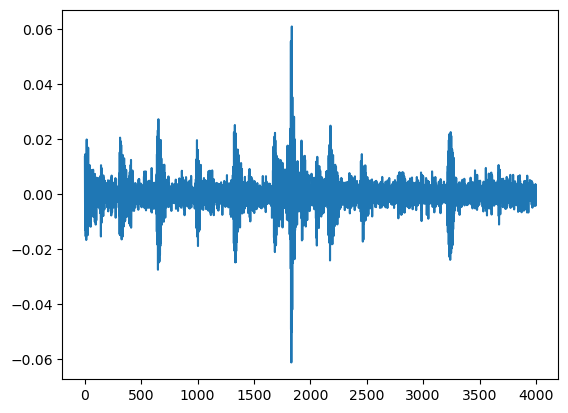

In [250]:
plt.figure()
plt.plot(waveform_noWhale.t().numpy())


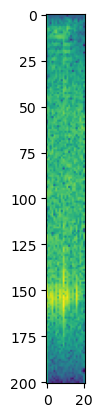

In [251]:
# Spectrogram
spectrogram_noWhale = torchaudio.transforms.Spectrogram()(waveform_noWhale)
# plot the spectrogram
plt.figure()
# scale the values with log2 and then select the first channel
plt.imshow(spectrogram_noWhale.log2()[0,:,:].numpy(), cmap='viridis')

## Explore RightWhale

In [252]:
# audio RightWhale
waveform_rightWhale, sr_rightWhale = torchaudio.load(r'.\train\train\1.wav')

print(type(waveform_rightWhale))
print(type(sr_rightWhale))
print(waveform_rightWhale.shape)
# 2000 data points per second, in total 4000 data points
print(sr_rightWhale)



<class 'torch.Tensor'>
<class 'int'>
torch.Size([1, 4000])
2000


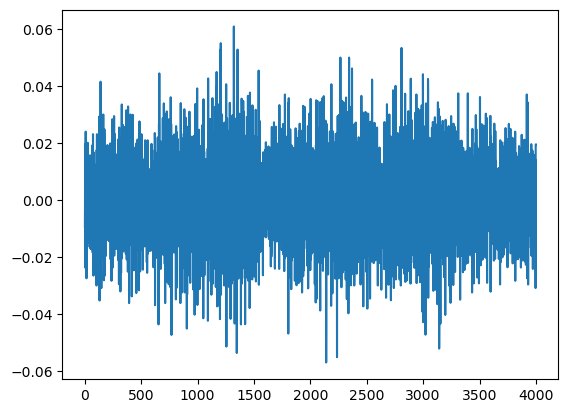

In [253]:
plt.figure()
plt.plot(waveform_rightWhale.t().numpy())


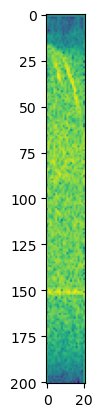

In [254]:
# Spectrogram
spectrogram_rightWhale = torchaudio.transforms.Spectrogram()(waveform_rightWhale)
# plot the spectrogram
plt.figure()
# scale the values with log2 and then select the first channel
plt.imshow(spectrogram_rightWhale.log2()[0,:,:].numpy(), cmap='viridis')


## Load data

In [255]:
# collect all the paths in the train folder
sound_files = os.listdir(r'.\train\train')
df_labels = pd.read_csv(r'.\train.csv')
print(len(sound_files))

10944


In [256]:
# get labels
train_labels = df_labels['class'].to_numpy()
print(train_labels[:10])
print(len(train_labels))

['NoWhale' 'RightWhale' 'NoWhale' 'NoWhale' 'NoWhale' 'NoWhale'
 'RightWhale' 'NoWhale' 'NoWhale' 'RightWhale']
10934


In [257]:
# remove the audios that are not valid
idx_labeled_audio_files = df_labels['idx'].to_numpy()
available_audio_files = []
for file in sound_files:
    try:
        idx = int(file.split('.')[0])
        available_audio_files.append(idx)
    except:
        print("Invalid file: ", file)

Invalid file:  8675(1).wav
Invalid file:  8676(1).wav
Invalid file:  8677(1).wav
Invalid file:  8678(1).wav
Invalid file:  8679(1).wav
Invalid file:  868(1).wav
Invalid file:  8680(1).wav
Invalid file:  8681(1).wav
Invalid file:  8682(1).wav
Invalid file:  8684(1).wav


In [258]:
available_audio_files = sorted(available_audio_files)
print(available_audio_files[:5])

[0, 1, 2, 3, 4]


In [259]:
# split the valid audio files into noWhale and RightWhale
noWhale_paths = []
rightWhale_paths = []
# assign the paths to the corresponding label
for idx in available_audio_files:
    if train_labels[idx] == 'NoWhale':
        noWhale_paths.append(idx)
    elif train_labels[idx] == 'RightWhale':
        rightWhale_paths.append(idx)
    else:
        print("Invalid label: ", train_labels[idx])

print(len(noWhale_paths))
print(len(rightWhale_paths))

5467
5467


In [260]:
# get the complete path of the valid audio files
noWhale_paths = [os.path.join(r'.\train\train', str(file) + '.wav') for file in noWhale_paths]
rightWhale_paths = [os.path.join(r'.\train\train', str(file) + '.wav') for file in rightWhale_paths]
print(noWhale_paths[:5])
print(rightWhale_paths[:5])

['.\\train\\train\\0.wav', '.\\train\\train\\2.wav', '.\\train\\train\\3.wav', '.\\train\\train\\4.wav', '.\\train\\train\\5.wav']
['.\\train\\train\\1.wav', '.\\train\\train\\6.wav', '.\\train\\train\\9.wav', '.\\train\\train\\10.wav', '.\\train\\train\\14.wav']


## Process data : Get images

In [261]:

if not os.path.exists(r'.\train_images_spectrogram'):
    os.makedirs(r'.\train_images_spectrogram\noWhale')
    os.makedirs(r'.\train_images_spectrogram\rightWhale')

    # save the spectrogram images of the noWhale

    for j, path in enumerate(noWhale_paths):
        if j % 1000 == 0:
            print(j)
        idx = int(path.split('\\')[-1].split('.')[0])
        waveform, sr = torchaudio.load(path)

        spectrogram_noWhale = torchaudio.transforms.Spectrogram()(waveform)
        spectrogram_path = os.path.join(r'.\train_images_spectrogram\noWhale', str(idx) + '.png')
        # scale the values with log2 and then select the first channel

        plt.imsave(spectrogram_path, spectrogram_noWhale.log2()[0,:,:].numpy(), cmap='viridis')
        j = j + 1

    # save the spectrogram images of the rightWhale

    for j, path in enumerate(rightWhale_paths):
        if j % 1000 == 0:
            print(j)
        idx = int(path.split('\\')[-1].split('.')[0])
        waveform, sr = torchaudio.load(path)

        spectrogram_rightWhale = torchaudio.transforms.Spectrogram()(waveform)
        spectrogram_path = os.path.join(r'.\train_images_spectrogram\rightWhale', str(idx) + '.png')
        # scale the values with log2 and then select the first channel

        plt.imsave(spectrogram_path, spectrogram_rightWhale.log2()[0,:,:].numpy(), cmap='viridis')
        j = j + 1



In [262]:
# Plot the unique dimensions of the images
path_rightWhale_directory = r'.\train_images_spectrogram\rightWhale'
path_noWhale_directory = r'.\train_images_spectrogram\noWhale'

image_noWhale_paths = os.listdir(path_noWhale_directory)
image_rightWhale_paths = os.listdir(path_rightWhale_directory)

# paths of all the images
image_noWhale_paths = [os.path.join(path_noWhale_directory, path) for path in image_noWhale_paths]
image_rightWhale_paths = [os.path.join(path_rightWhale_directory, path) for path in image_rightWhale_paths]

# get the dimensions of spectrogram images
image_dimensions = []
for path in image_noWhale_paths:
    image = plt.imread(path)
    image_dimensions.append(image.shape)
for path in image_rightWhale_paths:
    image = plt.imread(path)
    image_dimensions.append(image.shape)
print(set(image_dimensions))
"""
All the images have the same dimensions, so its not necessary to resize them to uniform dimensions
"""


{(201, 21, 4)}


'\nAll the images have the same dimensions, so its not necessary to resize them to uniform dimensions\n'

In [263]:
# This function will allow you to load and split your images into a test_loader and a train_loader

def load_images(images_path, batch_size, seed=10):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    #valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']

    images_dataset = datasets.ImageFolder(images_path, transform=transform)

    try:
        """
        We were spliting the train dataset into train and test for fine-tuning purposes, but the final model will be trained with the whole train dataset and evaluated with the test dataset in Kaggle. 
        """
        train_len = int(1 * len(images_dataset))
        test_len = len(images_dataset) - train_len

        train_dataset, test_dataset = random_split(images_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(seed))


        train_classes = []
        for _, label in train_dataset:
            train_classes.append(label)
        print("Classes", Counter(train_classes))
        
        train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
        test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

        return train_loader, test_loader
    except ValueError as e:
        print(f"ValueError: {e}")
        return None, None


## CNN model for spectrogram images

In [264]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [265]:
# Hiperparámetros
num_classes = 2
learning_rate = 0.0001
num_epochs = 5
batch_size = 30

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 35552
        self.layer1 = nn.Sequential( #(201,21)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (101,11)
        # 
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3328, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

In [266]:

def train(model, train_loader, num_epochs):
    loss_vals = []
    # Here we are setting up the loss function and the optimizer.
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    running_loss = 0.0
    total_step = len(train_loader)
    list_loss = []
    list_time = []
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            list_loss.append(loss.item())
            list_time.append(i)
            i += 1

            if (i + 1) % 5 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    print('Finished Training Trainset')
    return list_loss  # , loss_vals, list_time

In [267]:
model = CNN().to(device)
train_loader, test_loader = load_images(r'.\train_images_spectrogram', batch_size=30)

list_loss = train(model, train_loader, 20)

Classes Counter({0: 5467, 1: 5467})
Epoch [1/20], Step [5/365], Loss: 0.6679332256317139
Epoch [1/20], Step [10/365], Loss: 0.6928773522377014
Epoch [1/20], Step [15/365], Loss: 0.6930747628211975
Epoch [1/20], Step [20/365], Loss: 0.6929678320884705
Epoch [1/20], Step [25/365], Loss: 0.693106472492218
Epoch [1/20], Step [30/365], Loss: 0.692984938621521
Epoch [1/20], Step [35/365], Loss: 0.692997932434082
Epoch [1/20], Step [40/365], Loss: 0.6931353807449341
Epoch [1/20], Step [45/365], Loss: 0.6931032538414001
Epoch [1/20], Step [50/365], Loss: 0.6931150555610657
Epoch [1/20], Step [55/365], Loss: 0.6928814649581909
Epoch [1/20], Step [60/365], Loss: 0.6929956078529358
Epoch [1/20], Step [65/365], Loss: 0.6929753422737122
Epoch [1/20], Step [70/365], Loss: 0.6930407881736755
Epoch [1/20], Step [75/365], Loss: 0.6923993229866028
Epoch [1/20], Step [80/365], Loss: 0.6882518529891968
Epoch [1/20], Step [85/365], Loss: 0.6444014310836792
Epoch [1/20], Step [90/365], Loss: 0.6208812594413

In [268]:
# get the encoding of the labels
label_encoding = train_loader.dataset.dataset.class_to_idx
print(label_encoding)

{'noWhale': 0, 'rightWhale': 1}


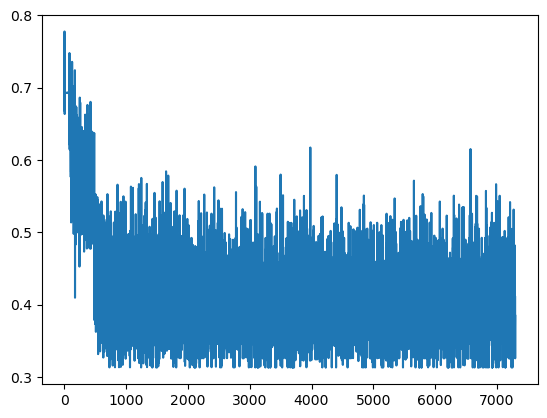

In [269]:
plt.plot(list_loss)

## Test the model only if the labels of test_loader are known

In [270]:
"""
Use this function if you are using the test dataset derived by the original train dataset (fine-tune purposes)
"""
temp = []
with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          temp.extend(predicted.cpu().numpy())
      print('Test Accuracy of the model on the 10000 train images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 train images: 91.53100420706055 %


In [211]:
print(len(temp))
print(temp[3146:3281])

10934
[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]


# Test the model on Kaggle

In [212]:
# Get all the paths of the test dataset
test_files = os.listdir(r'.\test\test')
print(len(test_files))
test_files = [os.path.join(r'.\test\test', file) for file in test_files]

1962


In [213]:
# Generate the spectrogram images of the original test dataset
if not os.path.exists(r'.\test_images_spectrogram'):
    os.makedirs(r'.\test_images_spectrogram\unknownLabel')
    # save the spectrogram images of the noWhale

    for j, path in enumerate(test_files):
        if j % 1000 == 0:
            print(j)
        idx = int(path.split('\\')[-1].split('.')[0])
        waveform, sr = torchaudio.load(path)

        spectrogram = torchaudio.transforms.Spectrogram()(waveform)
        spectrogram_path = os.path.join(r'.\test_images_spectrogram\unknownLabel', str(idx) + '.png')
        # scale the values with log2 and then select the first channel

        plt.imsave(spectrogram_path, spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
        j = j + 1





In [234]:
# Creation of a dataset without labels because i dont have the test labels and ImageFolder needs the labels
# to load the images
class TestDatasetNoLabels(Dataset):
    # pythoooooooooooooooooooooon
    def __init__(self, directory_path, transform):
        self.transform = transform
        self.test_path = directory_path
        self.image_files = os.listdir(directory_path)
        
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # full path
        img_tst_path = os.path.join(self.test_path, self.image_files[idx])
        # 3 channels -> RGB
        image = Image.open(img_tst_path).convert('RGB')
        image = self.transform(image)
        
        return image

def load_images_test(images_path, batch_size):
 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    dataset = TestDatasetNoLabels(images_path, transform)
    test_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=batch_size, num_workers=0)

    return test_loader

In [235]:
def test(modelo,test_loader):
    modelo.eval()
    with torch.no_grad():
        predictions = []
        for images in test_loader:
            images = images.to(device)
           
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_np = predicted.cpu().numpy()
            predictions.extend(predicted_np)
   
    return predictions




In [236]:

test_loader = load_images_test(r'.\test_images_spectrogram\unknownLabel', batch_size=30)



In [237]:
p = 0
for images in test_loader:
    print(images.shape)
    

torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30, 3, 201, 21])
torch.Size([30

In [238]:

Y_predicted = test(model, test_loader)


In [239]:
print(Y_predicted[:10])

[1, 0, 1, 0, 0, 0, 1, 1, 0, 1]


In [220]:
print(len(Y_predicted))

1962


In [221]:
# Encode the labels for Kaggle
idx_df = [i for i in range(0, len(Y_predicted))]
labels_encoded = []
for label in Y_predicted:
    if label == 0:
        labels_encoded.append('NoWhale')
    elif label == 1:
        labels_encoded.append('RightWhale')

In [222]:
df = pd.DataFrame({'idx': idx_df, 'class': labels_encoded})

In [223]:
df.head()

,idx,class
0,0,RightWhale
1,1,NoWhale
2,2,RightWhale
3,3,NoWhale
4,4,NoWhale


In [224]:
df.to_csv(r'.\test_pred.csv', index=False)

# Images for the presentation

In [ ]:
import torchvision

def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()


with torch.no_grad():
  model.to('cpu')

  img, label = next(iter(train_loader))
  
  img = img.unsqueeze(0)
  out = model(img)
  print(out)
  print ((out == out.max()).nonzero())

  out = model.layer1[0](img)
  Show(out, 'layer 1: Convolution output')
  out = model.layer1[1](out)
  Show(out, 'layer 1: Activation function output')
  out = model.layer1[2](out)
  Show(out, 'layer 1: Max-Pooling')


  out = model.layer2[0](out)
  Show(out, 'layer 2: Convolution output')
  out = model.layer2[1](out)
  Show(out, 'layer 2: Activation function output')
  out = model.layer2[2](out)
  Show(out, 'layer 2: Max-Pooling')

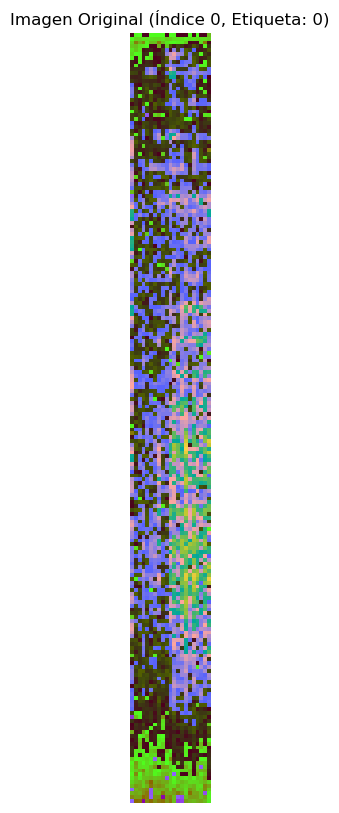

Layer 1: Convolución (Imagen 0)


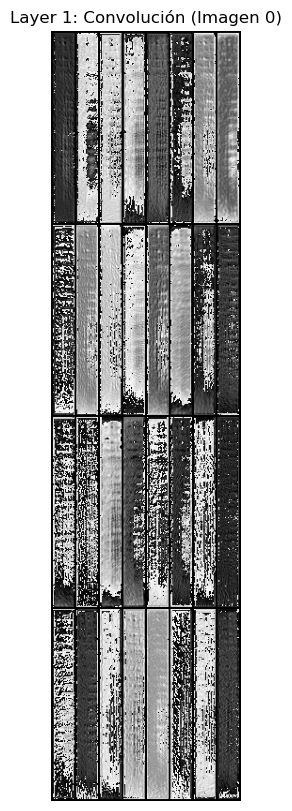

Layer 1: Después de ReLU (Imagen 0)


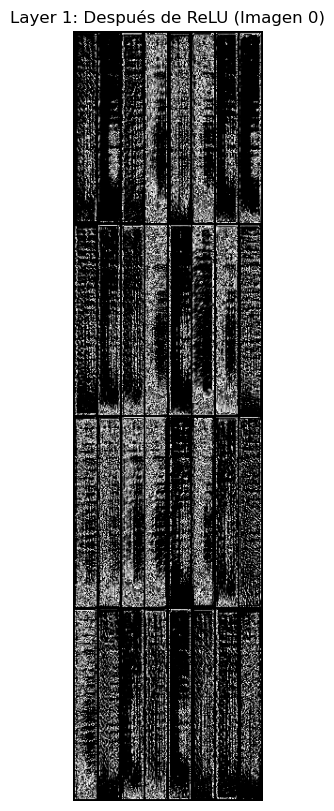

Layer 1: Después de MaxPooling (Imagen 0)


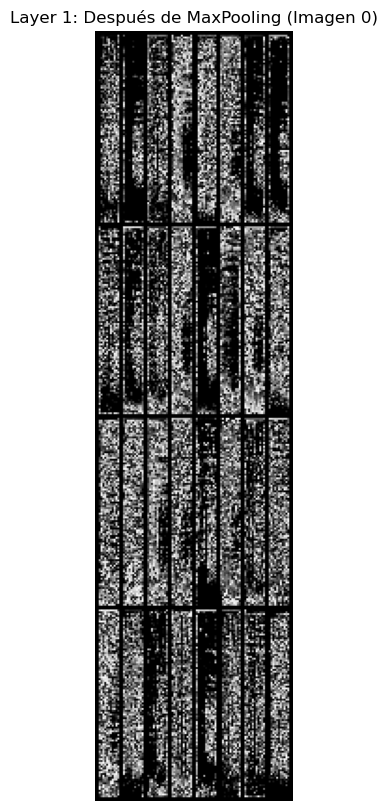

Layer 2: Convolución (Imagen 0)


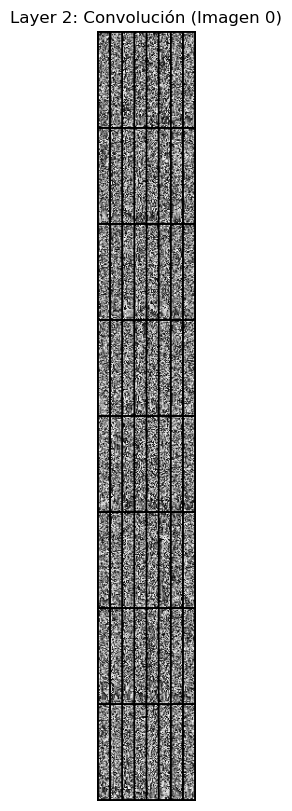

Layer 2: Después de ReLU (Imagen 0)


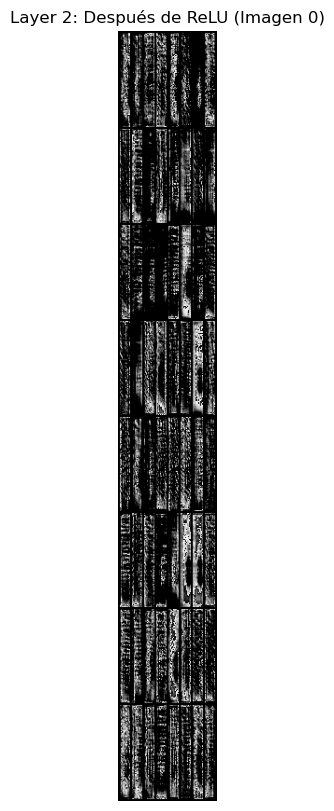

Layer 2: Después de MaxPooling (Imagen 0)


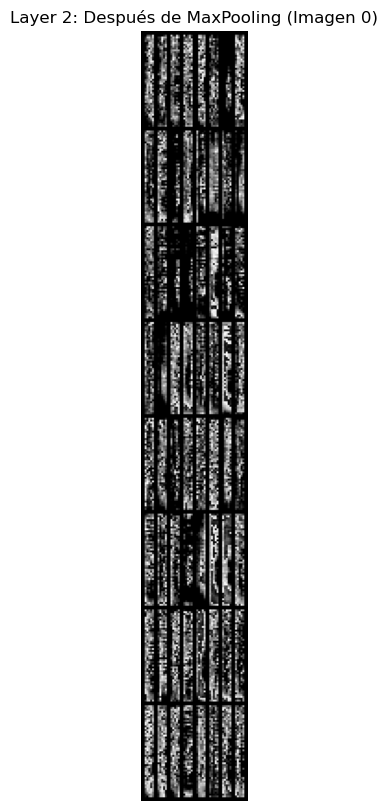

Layer 3: Convolución (Imagen 0)


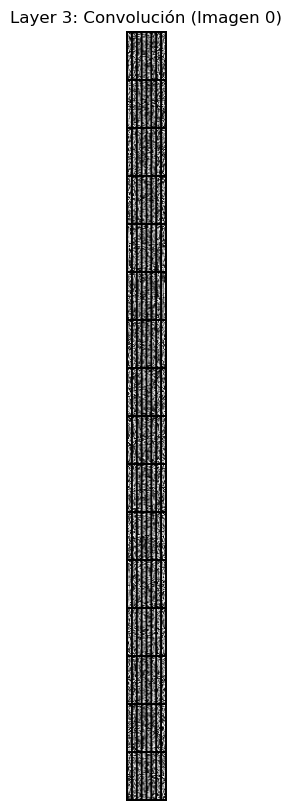

Layer 3: Después de ReLU (Imagen 0)


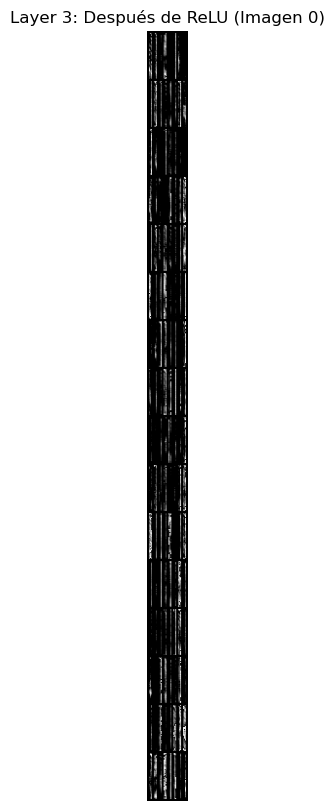

Layer 3: Después de MaxPooling (Imagen 0)


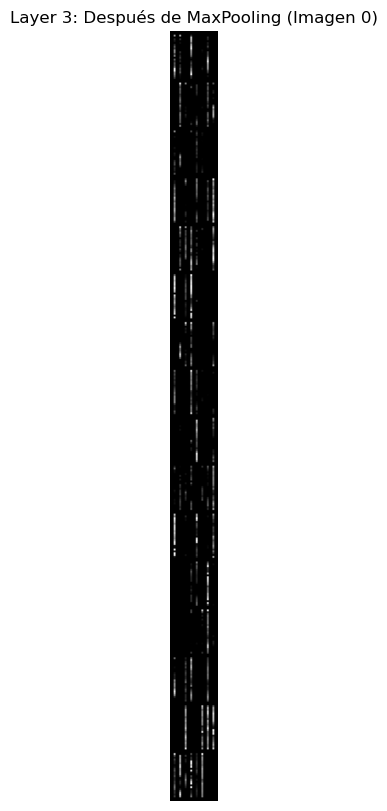

Layer 4: Convolución (Imagen 0)


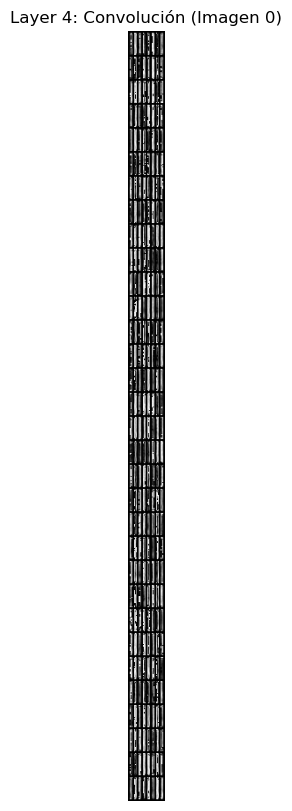

Layer 4: Después de ReLU (Imagen 0)


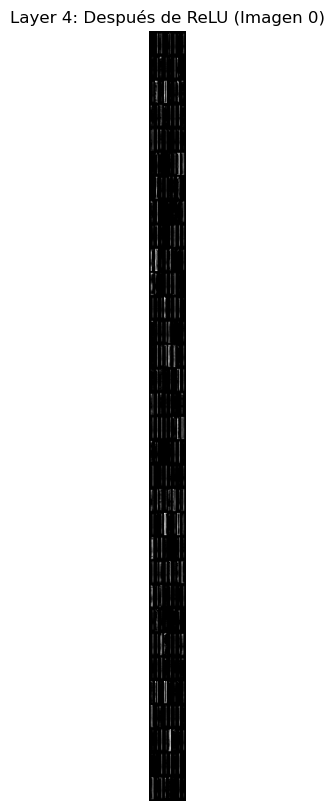

Layer 4: Después de MaxPooling (Imagen 0)


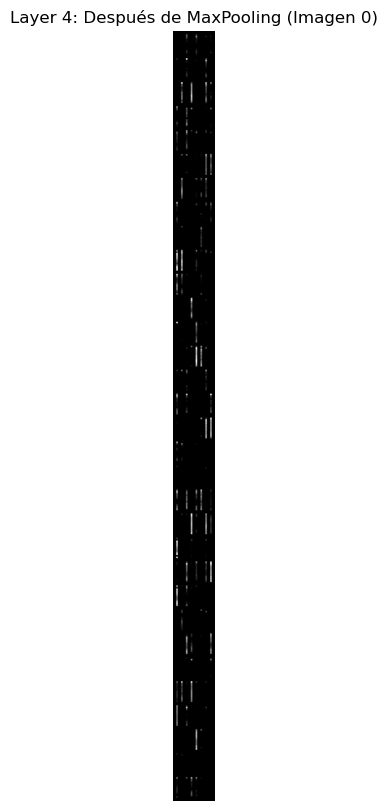

Salida después de la capa fully connected (Imagen 0):
tensor([[-0.2821,  0.7513,  0.9961,  0.2816,  0.0624,  0.8889, -0.7767,  0.8726,
          0.4854, -0.7600, -0.7782, -0.5151,  0.9262,  0.8152,  0.7577, -0.0877,
         -0.7697,  0.8207, -0.7606, -0.7562, -0.0095, -0.6647,  0.1270, -0.4589,
          0.7193, -0.9769, -0.2627,  0.4030, -0.8656,  0.8075,  0.5919, -0.3450,
          0.8869, -0.5760,  0.7472, -0.8887, -0.2092, -0.8624, -0.8002,  0.6599,
          0.6557, -0.8568, -0.7482,  0.4281,  0.8660, -0.3978,  0.9381,  0.8531,
          0.6031, -0.3711, -0.1383, -0.1848, -0.7748, -0.0427, -0.7842, -0.5204,
          0.8142,  0.3894,  0.6877, -0.2549,  0.5037, -0.8197,  0.4309,  0.4746,
          0.7294,  0.9718, -0.6852, -0.2164,  0.0038, -0.3418,  0.8681, -0.8458,
          0.7249,  0.1671,  0.4120, -1.0023, -0.9614, -0.0574, -0.8077,  0.3632,
          0.7592,  0.6237,  0.3852, -0.4263,  0.8507,  0.3062,  0.1511, -0.5459,
         -0.6766,  0.7339, -0.4243, -0.8183, -0.0178,  

In [247]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def Show(out, title=''):
    print(title)
    out = out.permute(1,0,2,3)
    grilla = torchvision.utils.make_grid(out)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(transforms.ToPILImage()(grilla), cmap='jet')
    plt.axis('off')
    plt.show()

def Show_Weight(out):
    grilla = torchvision.utils.make_grid(out)
    plt.figure(figsize=(10, 10))
    plt.imshow(transforms.ToPILImage()(grilla), cmap='jet')
    plt.axis('off')
    plt.show()

def visualize_cnn_layers(model, train_loader, image_index=0):
    with torch.no_grad():
        model.to('cpu')

        img, label = next(iter(train_loader))

        img_single = img[image_index].unsqueeze(0)

        plt.figure(figsize=(10, 10))
        plt.imshow(transforms.ToPILImage()(img_single[0]))
        plt.title(f'Imagen Original (Índice {image_index}, Etiqueta: {label[image_index]})')
        plt.axis('off')
        plt.show()

        out = img_single

        out = model.layer1[0](out)  
        Show(out, f'Layer 1: Convolución (Imagen {image_index})')

        out = model.layer1[1](out) 
        out = model.layer1[2](out) 
        Show(out, f'Layer 1: Después de ReLU (Imagen {image_index})')

        out = model.layer1[3](out)  
        out = model.layer1[4](out) 
        Show(out, f'Layer 1: Después de MaxPooling (Imagen {image_index})')

        out = model.layer2[0](out)  
        Show(out, f'Layer 2: Convolución (Imagen {image_index})')

        out = model.layer2[1](out)  
        out = model.layer2[2](out)  
        Show(out, f'Layer 2: Después de ReLU (Imagen {image_index})')

        out = model.layer2[3](out) 
        out = model.layer2[4](out) 
        Show(out, f'Layer 2: Después de MaxPooling (Imagen {image_index})')

        out = model.layer3[0](out) 
        Show(out, f'Layer 3: Convolución (Imagen {image_index})')

        out = model.layer3[1](out)  
        out = model.layer3[2](out)  
        Show(out, f'Layer 3: Después de ReLU (Imagen {image_index})')

        out = model.layer3[3](out)  
        out = model.layer3[4](out) 
        Show(out, f'Layer 3: Después de MaxPooling (Imagen {image_index})')

    
        out = model.layer4[0](out) 
        Show(out, f'Layer 4: Convolución (Imagen {image_index})')

        out = model.layer4[1](out)  
        out = model.layer4[2](out)  
        Show(out, f'Layer 4: Después de ReLU (Imagen {image_index})')

        out = model.layer4[3](out)  
        out = model.layer4[4](out)  
        Show(out, f'Layer 4: Después de MaxPooling (Imagen {image_index})')

       
        out = out.reshape(out.size(0), -1)
        out = model.fc(out)
        print(f"Salida después de la capa fully connected (Imagen {image_index}):")
        print(out)


visualize_cnn_layers(model, train_loader) 


In [246]:
img, label = next(iter(train_loader))
print(label)

tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1])
